In [71]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
import matplotlib.pyplot as plt
from scienceplots import styles  # This import assumes you need it for the styles

plt.style.use(['science', 'ieee'])

def process_tensorboard_directory(directory_path, tag_name='eval/ret/mean'):
    """
    Process all TensorBoard event files in a directory and extract data for a specific tag.

    Parameters:
    directory_path (str): Path to the directory containing TensorBoard event files.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    all_data = []
    for filename in os.listdir(directory_path):
        if filename.startswith("events.out.tfevents"):
            file_path = os.path.join(directory_path, filename)
            file_data = read_tensorboard_data(file_path, tag_name)
            all_data.extend(file_data)
    return all_data

def read_tensorboard_data(log_file_path, tag_name='eval/mean_reward'):
    """
    Read specified tag data from a TensorBoard log file.

    Parameters:
    log_file_path (str): Path to the TensorBoard log file.
    tag_name (str): Tag of the data to read.

    Returns:
    list of tuples: Each tuple contains (step, value) for the entries under the specified tag.
    """
    data = []
    try:
        for e in summary_iterator(log_file_path):
            for v in e.summary.value:
                if v.tag == tag_name:
                    if v.HasField('simple_value'):
                        data.append((e.step, v.simple_value))
                    elif v.HasField('tensor'):
                        value = tf.io.decode_raw(v.tensor.tensor_content, v.tensor.dtype)
                        data.append((e.step, float(value.numpy())))
                    else:
                        print(f"Unsupported value type in {log_file_path} for tag {tag_name}")
    except Exception as ex:
        print(f"Error reading {log_file_path}: {str(ex)}")
    return data

def create_dataframe(data, step_divisor=8):
    """
    Convert list of data into a DataFrame and perform necessary transformations.

    Parameters:
    data (list of tuples): Data as a list of (step, value) tuples.
    step_divisor (int): Divisor to calculate episodes from steps.

    Returns:
    DataFrame: Processed data with added columns for transformed rewards and episodes.
    """
    df = pd.DataFrame(data, columns=['Step', 'Mean Reward'])
    df.sort_values(by='Step', inplace=True)
    df['Transformed Reward'] = 1 / np.exp(1 / df['Mean Reward'])
    df['Episodes'] = df['Step'] / step_divisor
    return df

# Directory containing the TensorBoard files
PPO_tb_path = "/Users/thomasrochefort/Documents/GitHub/sogym_v2/tb_PPO/events.out.tfevents.1713636502.holodeck.2392170.10"
dreamerv3_tb_path = "/Users/thomasrochefort/Documents/GitHub/sogym_v2/tb_dreamerv3"

# Process data
PPO_data = process_tensorboard_directory(PPO_tb_path, 'eval/mean_reward')
dreamerv3_data = process_tensorboard_directory(dreamerv3_tb_path, 'eval/ret/mean')

# Convert data to DataFrames
PPO_df = create_dataframe(PPO_data)
dreamerv3_df = create_dataframe(dreamerv3_data)

# Append the dataframes
appended_df = pd.concat([dreamerv3_df, PPO_df], ignore_index=True)

# Find maximum value and normalize the data
maximum_value = appended_df[['Transformed Reward']].max().max()
appended_df['normalized_transformed_reward'] = appended_df['Transformed Reward'] / maximum_value

# Display the DataFrame
print(PPO_df)
print(dreamerv3_df)
print(appended_df.head())


          Step  Mean Reward  PPO Transformed Reward   Episodes
0         4992     0.051529            3.730734e-09      624.0
1         9984     0.024071            9.074985e-19     1248.0
2        14976     0.024071            9.074985e-19     1872.0
3        19968     0.028513            5.866571e-16     2496.0
4        24960     0.014457            9.119815e-31     3120.0
...        ...          ...                     ...        ...
5335  26637312     0.172009            2.986481e-03  3329664.0
5336  26642304     0.172430            3.029226e-03  3330288.0
5337  26647296     0.172430            3.029226e-03  3330912.0
5338  26652288     0.173477            3.137070e-03  3331536.0
5339  26657280     0.172701            3.056929e-03  3332160.0

[5340 rows x 4 columns]


In [74]:
import pandas as pd
import statsmodels.api as sm

# Filter out rows with NaN values in the normalized columns
PPO_data = appended_df[appended_df['normalized_ppo'].notna()]
dreamer_data = appended_df[appended_df['normalized_dreamerv3'].notna()]

# Fit a linear regression model for PPO data
X_PPO = sm.add_constant(PPO_data['Episodes'])  # Predictor
y_PPO = PPO_data['normalized_ppo']            # Response
model_PPO = sm.OLS(y_PPO, X_PPO).fit()
print(model_PPO.summary())

# Fit a linear regression model for Dreamer V3 data
X_dreamer = sm.add_constant(dreamer_data['Episodes'])  # Predictor
y_dreamer = dreamer_data['normalized_dreamerv3']       # Response
model_dreamer = sm.OLS(y_dreamer, X_dreamer).fit()
print(model_dreamer.summary())


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:         normalized_ppo   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     1941.
Date:                Tue, 23 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:45:06   Log-Likelihood:                 1205.5
No. Observations:                5340   AIC:                            -2407.
Df Residuals:                    5338   BIC:                            -2394.
Df Model:                           1                                         
Covariance Type:            nonrobust  

In [153]:
# Create a new DataFrame with the specific X value at which you want to predict the y-value
predict_df = pd.DataFrame({'const': [1], 'Episodes': [100]})  # Note: 'const' column must be included if the model includes it

# Predicting the y-value at X = 100
predicted_value = model.predict(predict_df)
print(f'The predicted y-value at X = 100 is {predicted_value[0]}')

The predicted y-value at X = 100 is 0.07046716740511552


/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/3867189498.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ppo_df['Predicted_PPO'] = model_PPO.predict(sm.add_constant(ppo_df['Episodes']))
/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/3867189498.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dreamer_df['Predicted_Dreamer'] = model_d3.predict(sm.add_constant(dreamer_df['Episodes']))
/var/folders/74/dbvs70p114jg4xwq3mjmhr6w0000gn/T/ipykernel_87821/3867189498.py:78

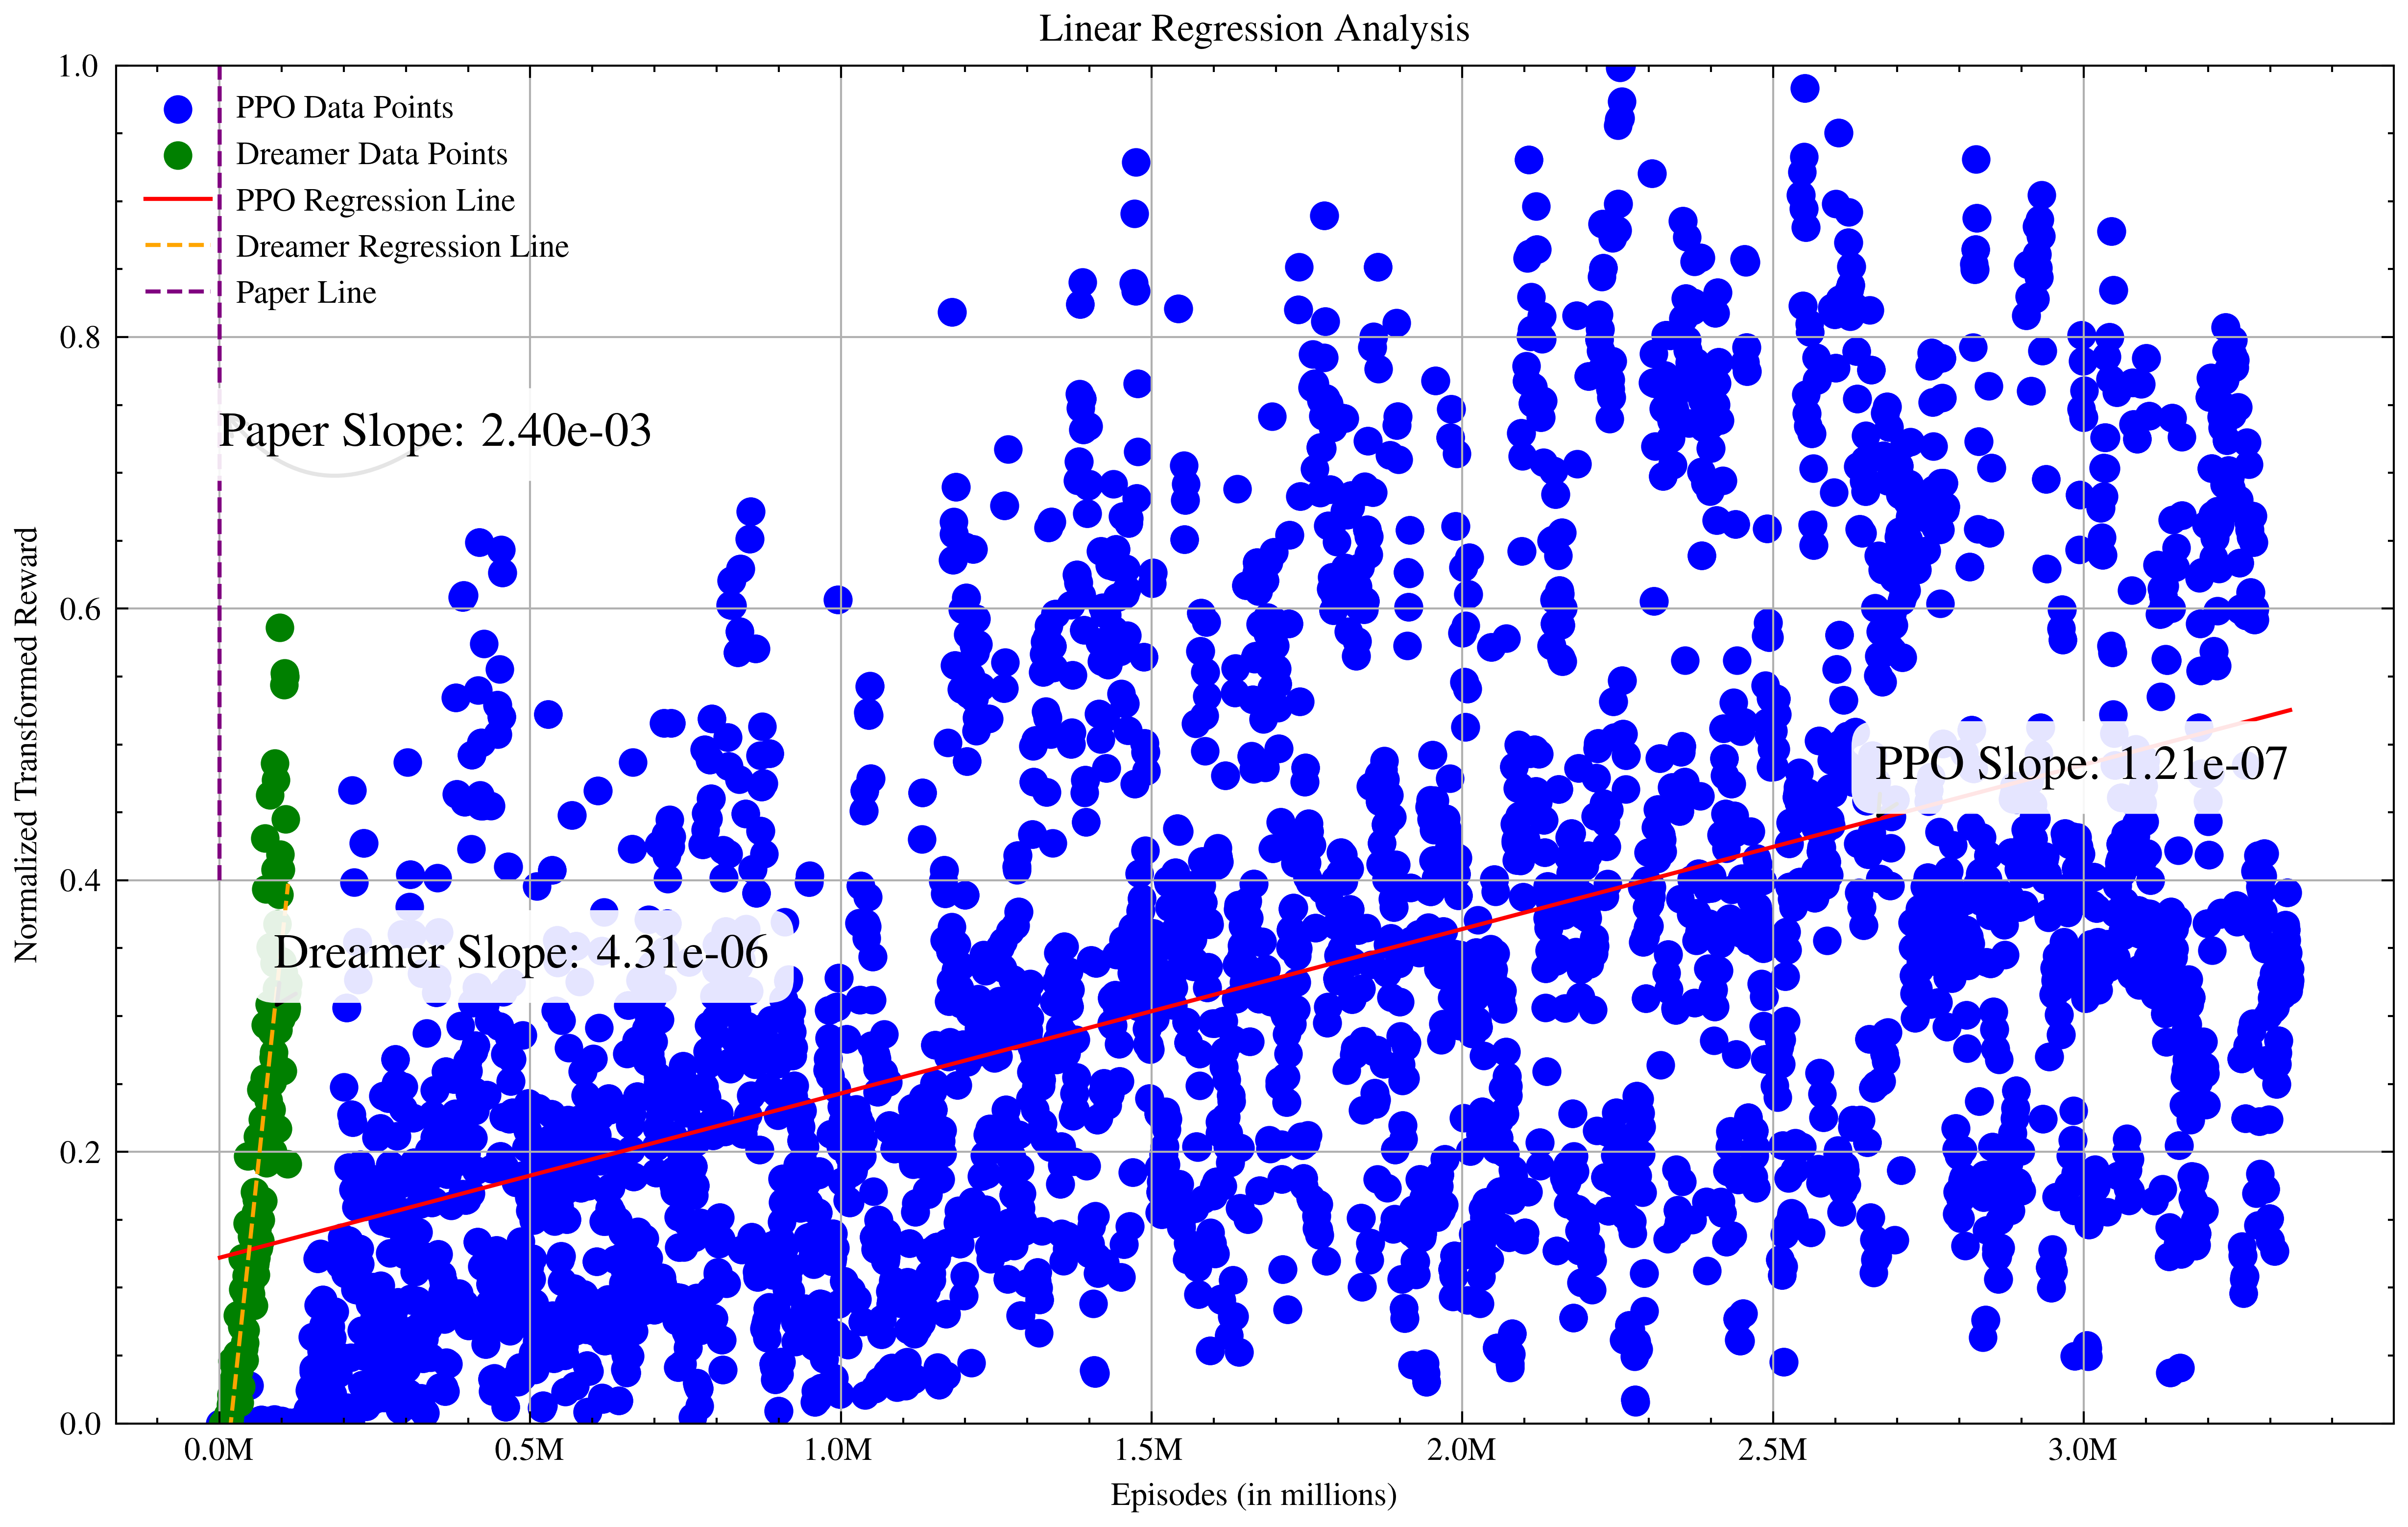

In [77]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming appended_df, model_PPO, and model_d3 are already defined as per your description

# Create separate DataFrames for PPO and Dreamer
ppo_df = appended_df[appended_df['normalized_ppo'].notna()]
dreamer_df = appended_df[appended_df['normalized_dreamerv3'].notna()]

# Predict values for the regression lines
ppo_df['Predicted_PPO'] = model_PPO.predict(sm.add_constant(ppo_df['Episodes']))
dreamer_df['Predicted_Dreamer'] = model_dreamer.predict(sm.add_constant(dreamer_df['Episodes']))

# Slope and intercept from the paper
paper_slope = 0.0024
paper_intercept = 0.40

# Generate x-values for the paper line
paper_x = np.linspace(0, max(ppo_df['Episodes'].max(), dreamer_df['Episodes'].max()), 100)
paper_y = paper_slope * paper_x + paper_intercept

plt.figure(figsize=(10, 6))

# Plot scatter points for PPO
plt.scatter(ppo_df['Episodes'], ppo_df['normalized_ppo'], color='blue', label='PPO Data Points')

# Plot scatter points for Dreamer
plt.scatter(dreamer_df['Episodes'], dreamer_df['normalized_dreamerv3'], color='green', label='Dreamer Data Points')

# Plot regression line for PPO
plt.plot(ppo_df['Episodes'], ppo_df['Predicted_PPO'], color='red', label='PPO Regression Line')

# Plot regression line for Dreamer
plt.plot(dreamer_df['Episodes'], dreamer_df['Predicted_Dreamer'], color='orange', label='Dreamer Regression Line')

# Plot the line from the paper
plt.plot(paper_x, paper_y, color='purple', linestyle='--', label='Paper Line')

# Calculate positions for the annotations
x_pos_ppo = ppo_df['Episodes'].max() * 0.8
y_pos_ppo = ppo_df['Predicted_PPO'].iloc[(ppo_df['Episodes'].searchsorted(x_pos_ppo))]

x_pos_dreamer = dreamer_df['Episodes'].max() * 0.8
y_pos_dreamer = dreamer_df['Predicted_Dreamer'].iloc[(dreamer_df['Episodes'].searchsorted(x_pos_dreamer))]

x_pos_paper =  0.22
y_pos_paper = 0.75

# Annotation for the slope of PPO in scientific notation
slope_ppo = model_PPO.params['Episodes']
plt.annotate(f'PPO Slope: {slope_ppo:.2e}', xy=(x_pos_ppo, y_pos_ppo), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope of Dreamer in scientific notation
slope_dreamer = model_dreamer.params['Episodes']
plt.annotate(f'Dreamer Slope: {slope_dreamer:.2e}', xy=(x_pos_dreamer, y_pos_dreamer), textcoords="offset points", xytext=(0,10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

# Annotation for the slope from the paper
plt.annotate(f'Paper Slope: {paper_slope:.2e}', xy=(x_pos_paper, min(1.0, y_pos_paper)), textcoords="offset points", xytext=(0,-10),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.5"), fontsize=12,
             bbox=dict(boxstyle="round,pad=0.5", facecolor='white', edgecolor='none', alpha=0.9))

plt.title('Linear Regression Analysis')
plt.xlabel('Episodes (in millions)')
plt.ylabel('Normalized Transformed Reward')

# Set y-axis limits from 0.0 to 1.0
plt.ylim(0.0, 1.0)

plt.legend()
plt.grid()

# Get current x-axis ticks and convert them to millions
current_ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels([f'{x/1_000_000:.1f}M' for x in current_ticks])

plt.show()
